In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise

In [2]:
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_cpk.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_expQ.npz')

In [3]:
n_xeft = data_xeft["dens_scaled"]
n_pqcd = data_pqcd["dens_scaled"]
p_mean_xeft = data_xeft["mean"][:, -1]
p_stdv_xeft = data_xeft["std_dev"][:, -1]

p_mean_pqcd = data_pqcd["mean"][:, -1]
p_stdv_pqcd = data_pqcd["std_dev"][:, -1]

In [4]:
def get_closest_mask(array, values):
    """Returns a mask corresponding to the locations in array that are closest to values.
    
    array and values must be sorted
    """
    idxs = np.searchsorted(array, values, side="left")

    # find indexes where previous index is closer
    prev_idx_is_less = ((idxs == len(array))|(np.fabs(values - array[np.maximum(idxs-1, 0)]) < np.fabs(values - array[np.minimum(idxs, len(array)-1)])))
    idxs[prev_idx_is_less] -= 1
    return np.isin(np.arange(len(array)), idxs)
    # return np.array([np.isin(i, idxs) for i in np.arange(len(array))])

def get_linear_mask_in_log_space(x, x_min, x_max, log_x_step, base=10):
    lin_x = np.arange(
        np.emath.logn(n=base, x=x_min),
        np.emath.logn(n=base, x=x_max),
        log_x_step
    )
    closest = get_closest_mask(np.emath.logn(n=base, x=x), lin_x)
    return (x <= x_max) & (x >= x_min) & closest

In [5]:
mask_train_xeft = get_linear_mask_in_log_space(n_xeft, x_min=1, x_max=5, log_x_step=0.15, base=10)
n_train_xeft = n_xeft[mask_train_xeft]
p_train_xeft = p_mean_xeft[mask_train_xeft]
p_train_stdv_xeft = p_stdv_xeft[mask_train_xeft]

mask_train_pqcd = get_linear_mask_in_log_space(n_pqcd, x_min=5, x_max=101, log_x_step=0.2, base=10)
n_train_pqcd = n_pqcd[mask_train_pqcd]
p_train_pqcd = p_mean_pqcd[mask_train_pqcd]
p_train_stdv_pqcd = p_stdv_pqcd[mask_train_pqcd]

In [6]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

(0.0, 1.5)

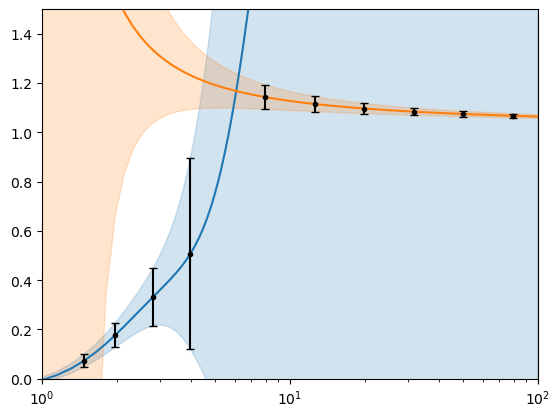

In [7]:
fig, ax = plt.subplots()
ax: Axes

color_xeft = "C0"
color_pqcd = "C1"

ax.semilogx(n_xeft, p_mean_xeft, color=color_xeft)
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=n_train_xeft, y=p_train_xeft, yerr=p_train_stdv_xeft, **errorbar_kwargs)
ax.semilogx(n_pqcd, p_mean_pqcd, color=color_pqcd)
ax.fill_between(n_pqcd, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
ax.errorbar(x=n_train_pqcd, y=p_train_pqcd, yerr=p_train_stdv_pqcd, **errorbar_kwargs)
ax.set_xlim(1, 100)
ax.set_ylim(0, 1.5)

In [8]:
X_train_xeft = np.log10(n_train_xeft)[:, None]
X_train_pqcd = np.log10(n_train_pqcd)[:, None]

p_train_cov_xeft = p_train_stdv_xeft**2 * np.eye(len(p_train_stdv_xeft))
p_train_cov_pqcd = p_train_stdv_pqcd**2 * np.eye(len(p_train_stdv_pqcd))

p_train_cov_xeft = np.sqrt(p_train_cov_xeft) @ RBF()(X_train_xeft) @ np.sqrt(p_train_cov_xeft)
p_train_cov_pqcd = np.sqrt(p_train_cov_pqcd) @ RBF()(X_train_pqcd) @ np.sqrt(p_train_cov_pqcd)

noise_off_diag = np.zeros((p_train_cov_xeft.shape[0], p_train_cov_pqcd.shape[1]))
noise = np.block([
    [p_train_cov_xeft, noise_off_diag],
    [noise_off_diag.T, p_train_cov_pqcd]
])
noise

array([[6.78113458e-04, 1.28594957e-03, 2.93725215e-03, 9.21728027e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.28594957e-03, 2.47792218e-03, 5.77009427e-03, 1.84551685e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [2.93725215e-03, 5.77009427e-03, 1.37527286e-02, 4.50099670e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.21728027e-03, 1.84551685e-02, 4.50099670e-02, 1.50691514e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.47648576e-03, 1.49680624e-03, 9.54871712e-04, 6.21398070e-04,
        4.06276012e-04, 2.64442229e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

In [9]:
# kernel = C(constant_value=10, constant_value_bounds="fixed") * RBF()
kernel = C() * RBF()

X_train = np.log10(np.concatenate((n_train_xeft, n_train_pqcd))[:, None])
y_train = np.concatenate((p_train_xeft, p_train_pqcd))

gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=noise
)
# gp = GaussianProcessRegressor(
#     kernel=kernel,
#     alpha=np.diag(noise)
# )

gp.fit(X_train, y_train)

GaussianProcessRegressor2dNoise(alpha=array([[6.78113458e-04, 1.28594957e-03, 2.93725215e-03, 9.21728027e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.28594957e-03, 2.47792218e-03, 5.77009427e-03, 1.84551685e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [...
        1.64356507e-04, 1.20513370e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.06276012e-04, 2.88057986e-04, 2.15336702e-04, 1.64356507e-04,
        1.26050547e-04, 9.61789139e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.64442229e-04, 1.95111088e-04, 1.51738291e-04, 1.20513370e-04,
        9.61789139e-05, 7.63539854e-05]]),
                                kernel=1**2 * RBF(length_scale=1))

In [10]:
gp.kernel_

0.65**2 * RBF(length_scale=0.363)

In [11]:
n_pred = np.logspace(0, 2, 100, base=10)
X = np.log10(n_pred)[:, None]
y_pred, y_stdv = gp.predict(X, return_std=True)

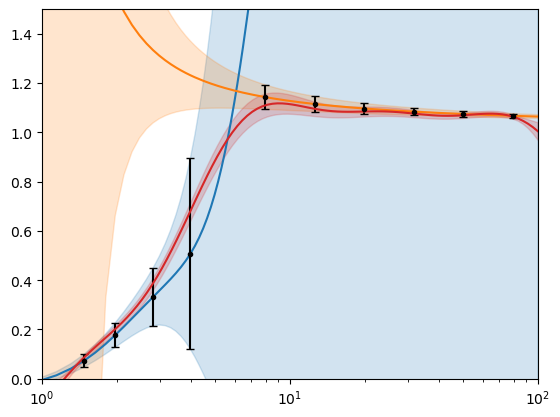

In [12]:
fig, ax = plt.subplots()

ax.semilogx(n_xeft, p_mean_xeft, color=color_xeft)
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=n_train_xeft, y=p_train_xeft, yerr=p_train_stdv_xeft, **errorbar_kwargs)
ax.semilogx(n_pqcd, p_mean_pqcd, color=color_pqcd)
ax.fill_between(n_pqcd, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
ax.errorbar(x=n_train_pqcd, y=p_train_pqcd, yerr=p_train_stdv_pqcd, **errorbar_kwargs)
ax.set_xlim(1, 100)
ax.set_ylim(0, 1.5)

ax.plot(n_pred, y_pred, c="C3")
ax.fill_between(n_pred, y_pred-y_stdv, y_pred+y_stdv, color="C3", alpha=0.2)